In [22]:
import os, sys
sys.path.append('..')

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='cobra')

from cobra import io, Model, Solution
from scripts.helpers.model import rxn_in_model, met_in_model, add_single_gene_reaction_pair
from scripts.opt._fba import flux_balance_analysis
from scripts.opt._fva import run_flux_variability_analysis

In [27]:
# Gap-filled model
model = io.read_sbml_model('../data/fill/xmls/MNL_iCre1355_auto_GAPFILL.xml')

# Add exchange reaction
ERG = "ergosterol_c"
ERGEXCH = "ERGOSTEROLEXCH"
if not rxn_in_model(model, ERGEXCH):
    add_single_gene_reaction_pair(
        model=model, 
        gene_id="EXCHERG_GENE",
        reaction_id=ERGEXCH,
        reaction_name="Ergosterol exchange (assumption)", 
        reaction_subsystem="Exchange", 
        metabolites=[(-1, ERG)],
        reversible=True
    )

No objective coefficients in model. Unclear what should be optimized


In [29]:
# Run FVA on Biomass w/ ERGEXCH objective
BIOMASS_fva = run_flux_variability_analysis(
    model,
    loopless=True,
    pfba_factor = None,
    objectives=[ERGEXCH],
    reactions=['Biomass_Chlamy_auto'],
)

BIOMASS_fva

# CO2th_fva = run_flux_variability_analysis(
    # model,
    # loopless=True,
    # pfba_factor=None,
    # objectives=[ERGEXCH],
    # reactions=['CO2th'],
# )

# CO2th_fva

Infeasible: There is no optimal solution for the chosen objective! (infeasible).

In [28]:
BIOMASS = model.reactions.get_by_id('Biomass_Chlamy_auto')
CO2th = model.reactions.get_by_id('CO2th')

options = {
    'xlim': (BIOMASS.lower_bound, BIOMASS.upper_bound),
    'ylim': (0.0, 77.5),
    'steps': 30,
}

COMPUTE_BIOMASS_STEP = lambda i: i * (options['xlim'][1] - options['xlim'][0]) / options['steps']
COMPUTE_CO2TH_STEP = lambda j: j * (options['ylim'][1] - options['ylim'][0]) / options['steps']

results = {}
for i in [COMPUTE_BIOMASS_STEP(step) for step in range(1,options['steps']+1)]:
    # Perform analysis for each step
    BIOMASS.upper_bound = i
    BIOMASS.lower_bound = i
    
    print(i)

    # solution = flux_balance_analysis(
    #     model,
    #     objectives=[ERGEXCH],
    #     loopless=False,
    #     is_pfba=True
    # )
    # print(f"Biomass: {i}, ERGOSTEROLEXCH: {solution.fluxes[ERGEXCH]}")
    # results[i] = solution.fluxes[ERGEXCH]
    # for j in [COMPUTE_CO2TH_STEP(step) for step in range(1,options['steps']+1)]:
    #     # Set bounds
    #     BIOMASS.upper_bound = i
    #     CO2th.upper_bound = j
    #     BIOMASS.lower_bound = i
    #     CO2th.lower_bound = j

    #     # Run FBA
    #     solution = flux_balance_analysis(
    #         model,
    #         objectives=[ERGEXCH],
    #         loopless=False,
    #         is_pfba=True
    #     )
    #     results[i][j] = solution.fluxes[ERGEXCH]
    #     print(f"Biomass: {i}, CO2th: {j}, ERGOSTEROLEXCH: {solution.fluxes[ERGEXCH]}")

33.333333333333336
66.66666666666667
100.0
133.33333333333334
166.66666666666666
200.0
233.33333333333334
266.6666666666667
300.0
333.3333333333333
366.6666666666667
400.0
433.3333333333333
466.6666666666667
500.0
533.3333333333334
566.6666666666666
600.0
633.3333333333334
666.6666666666666
700.0
733.3333333333334
766.6666666666666
800.0
833.3333333333334
866.6666666666666
900.0
933.3333333333334
966.6666666666666
1000.0


Figure saved to: ../results/plots/biomass_ergosterol_phase_plane.png


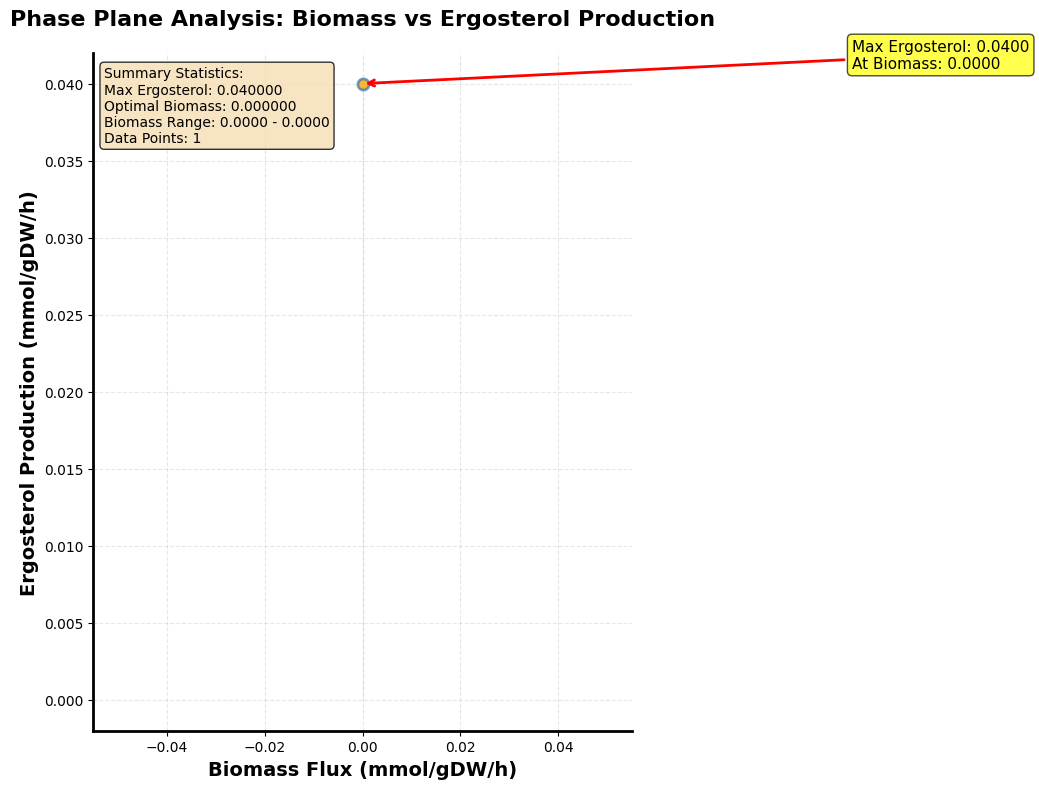


Numerical Results:
Biomass: 0.000000 | Ergosterol: 0.040000


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_biomass_ergosterol_relationship(results, save_path=None):
    """
    Plot the relationship between biomass flux and ergosterol production
    
    Parameters:
    - results: Dictionary with biomass flux as keys and ergosterol production as values
    - save_path: Optional path to save the figure
    """
    
    # Extract data from results
    biomass_flux = list(results.keys())
    ergosterol_production = list(results.values())
    
    # Sort by biomass flux for better plotting
    sorted_data = sorted(zip(biomass_flux, ergosterol_production))
    biomass_flux_sorted = [x[0] for x in sorted_data]
    ergosterol_production_sorted = [x[1] for x in sorted_data]
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Main scatter plot with line
    plt.plot(biomass_flux_sorted, ergosterol_production_sorted, 'o-', 
             linewidth=3, markersize=8, color='steelblue', 
             markerfacecolor='orange', markeredgecolor='steelblue', 
             markeredgewidth=2, alpha=0.8)
    
    # Fill area under curve for better visualization
    plt.fill_between(biomass_flux_sorted, ergosterol_production_sorted, 
                     alpha=0.3, color='lightblue')
    
    # Styling
    plt.xlabel('Biomass Flux (mmol/gDW/h)', fontsize=14, fontweight='bold')
    plt.ylabel('Ergosterol Production (mmol/gDW/h)', fontsize=14, fontweight='bold')
    plt.title('Phase Plane Analysis: Biomass vs Ergosterol Production', 
              fontsize=16, fontweight='bold', pad=20)
    
    # Grid
    plt.grid(True, alpha=0.3, linestyle='--')
    
    # Remove top and right spines
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    
    # Add statistics
    max_ergosterol = max(ergosterol_production_sorted)
    optimal_biomass = biomass_flux_sorted[ergosterol_production_sorted.index(max_ergosterol)]
    
    # Add annotation for maximum point
    plt.annotate(f'Max Ergosterol: {max_ergosterol:.4f}\nAt Biomass: {optimal_biomass:.4f}',
                xy=(optimal_biomass, max_ergosterol),
                xytext=(optimal_biomass + 0.1, max_ergosterol + 0.001),
                arrowprops=dict(arrowstyle='->', color='red', lw=2),
                fontsize=11, bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    # Add text box with summary statistics
    stats_text = f'''
    Summary Statistics:
    Max Ergosterol: {max_ergosterol:.6f}
    Optimal Biomass: {optimal_biomass:.6f}
    Biomass Range: {min(biomass_flux_sorted):.4f} - {max(biomass_flux_sorted):.4f}
    Data Points: {len(biomass_flux_sorted)}
    '''
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        import os
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")
    
    plt.show()
    
    return biomass_flux_sorted, ergosterol_production_sorted

# Plot the results
save_path = '../results/plots/biomass_ergosterol_phase_plane.png'
biomass_data, ergosterol_data = plot_biomass_ergosterol_relationship(results, save_path)

# Print numerical summary
print("\nNumerical Results:")
print("=" * 50)
for biomass, ergosterol in zip(biomass_data, ergosterol_data):
    print(f"Biomass: {biomass:.6f} | Ergosterol: {ergosterol:.6f}")